# Statistics of sound clips
### Four datasets: Oswald, Gillispie, DCLDE2011 & Watkin

In [1]:
# import os
import glob
# import random

# import numpy as np
import pandas as pd
# import librosa
# from specAugment.spec_augment_tensorflow import *

import lib_feature
from lib_augment import *

In [2]:
# priori knowledge
species_dict = {'NO': 0, 'BD': 1, 'MH': 2, 'CD': 3, 'STR': 4, 'SPT': 5, 'SPIN': 6, 'PLT': 7, 'RD': 8, 'RT': 9,
                'WSD': 10, 'FKW': 11, 'BEL': 12, 'KW': 13, 'WBD': 14, 'DUSK': 15, 'FRA': 16, 'PKW': 17, 'LPLT': 18,
                'NAR': 19, 'CLY': 20, 'SPE': 21, 'ASP': 22}
species_all = list(species_dict.keys())
datasets = ['oswald', 'gillispie', 'dclde2011', 'watkin']

fs = 48000
time_reso = 0.02
hop_length = int(time_reso*fs)

clip_length = 2*fs  # 96,000 samples
freq_low = 50  # mel-scale =~ 2 kHz
shift_time_max = int(0.5/time_reso)
shift_freq_max = 10

random.seed(0)

# where the sound clips are
dataset_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset'

clip_paths = dict()
for dd in datasets:
    clip_paths.update({dd: os.path.join(dataset_path, '__'+dd, '__sound_clips')})

In [3]:
# statistics of sound clips
print('Build labels & dataframe from the filenames')
dataset_df = dict()
for dd in datasets:
    # for dd in [datasets[0]]:
    print('..'+dd)
    # search by the species names in the filenames
    wav_list = glob.glob(clip_paths[dd]+'/*.wav')
    wav_list.sort()
    wav_basename = [os.path.basename(ww) for ww in wav_list]

    species_list = []
    clip_id = []
    deployment_list = []
    for ww in range(len(wav_basename)):
        species_file, clipid_file, deploy_file = wavname_to_meta(wav_basename[ww], dd)
        species_list.append(species_file)
        clip_id.append(clipid_file)
        deployment_list.append(deploy_file)

    # build dataframe: dataset, base filename, species, clip id
    dataset_df.update({dd: pd.DataFrame(list(zip([dd]*len(wav_basename), wav_basename, species_list, clip_id, deployment_list)),
                                        columns=['dataset', 'filename', 'species', 'id', 'deployment'])})


Build labels & dataframe from the filenames
..oswald
..gillispie
..dclde2011
..watkin


In [4]:
df_total = pd.concat(list(dataset_df.values()))

In [5]:
df_total.shape

(105838, 5)

In [6]:
df_total.sample(n=10)

,dataset,filename,species,id,deployment
6529,gillispie,FKW_48kHz_to_48kHz_15587.wav,FKW,15587,48kHz
19540,oswald,SPIN_PICEAS2005_48kHz_a104_7176.wav,SPIN,7176,PICEAS2005
3447,gillispie,CD_48kHz_to_48kHz_13529.wav,CD,13529,48kHz
10482,oswald,NO_HICEAS2002_48kHz_s167_924.wav,NO,924,HICEAS2002
16904,dclde2011,MH_18741.wav,MH,18741,dclde2011
4674,watkin,NO_SPE_all_cuts_48k_1110.wav,NO,1110,allcuts
13481,oswald,NO_PICEAS2005_48kHz_a57_2825.wav,NO,2825,PICEAS2005
4181,watkin,NO_KW_all_cuts_48k_126.wav,NO,126,allcuts
24322,dclde2011,MH_26159.wav,MH,26159,dclde2011
23169,dclde2011,MH_25006.wav,MH,25006,dclde2011


## Total number of 2-sec sound clips

In [7]:
df_species = df_total[df_total['species']!='NO']
df_noise = df_total[df_total['species'] == 'NO']

df_species.shape

(88328, 5)

## Number of sound clips for each dataset

In [8]:
df_species['dataset'].value_counts()

dclde2011    32113
gillispie    23022
oswald       18987
watkin       14206
Name: dataset, dtype: int64

In [9]:
df_species.value_counts('species')

species
MH      20568
CD      11957
BD      10283
SPE      6757
SPT      6234
FKW      5538
STR      5498
PLT      4351
SPIN     4301
WSD      4169
KW       2016
RD       1853
RT       1321
LPLT     1080
FRA       822
DUSK      513
WBD       402
BEL       292
CLY       226
ASP        90
PKW        57
dtype: int64

## Clip distribution over species for each dataset

In [10]:
for dd in datasets:
    print('Dataset: '+dd)
    print(df_species[df_species['dataset']==dd].value_counts(subset='species', sort=False))
    print()

Dataset: oswald
species
BD      1911
CD      4740
FKW     3180
PLT     2007
RT      1311
SPIN    1035
SPT     2271
STR     2532
dtype: int64

Dataset: gillispie
species
BD      1785
BEL      220
CD      3188
DUSK     504
FKW     2088
FRA      341
KW      1556
LPLT     164
PKW       57
PLT      864
RD      1762
SPIN     612
SPT     3364
STR     2682
WBD      268
WSD     3567
dtype: int64

Dataset: dclde2011
species
BD       6581
CD       3160
MH      20536
SPIN     1836
dtype: int64

Dataset: watkin
species
ASP       90
BD         6
BEL       72
CD       869
CLY      226
DUSK       9
FKW      270
FRA      481
KW       460
LPLT     916
MH        32
PLT     1480
RD        91
RT        10
SPE     6757
SPIN     818
SPT      599
STR      284
WBD      134
WSD      602
dtype: int64



## Whistle Classifier on Github 

https://github.com/atoultaro/whistle_classifier

In [11]:
from lib_augment import *
%matplotlib inline
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt

In [12]:
def spectrogram_draw(spectro, row):
    float_min = 1.e-10
    spectro_log_in = 20*np.log10(spectro+float_min)

    spectro_log_in = spectro_log_in - spectro_log_in.max()
    spectro_log_in_max = spectro_log_in.max()
    spectro_log_in[spectro_log_in < spectro_log_in_max-100] = spectro_log_in_max - 100

    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 1)
    ax.title.set_text(row['dataset']+' '+row['species'])
    specshow(spectro_log_in, sr=fs, y_axis='linear', x_axis='time', ax=ax)

In [13]:
row  = (df_species[df_species['species']=='BD'].sample(1)).iloc[0]
# df_bd  = df_species[df_species['species']=='BD'].sample(20)

In [14]:
row

dataset         dclde2011
filename      BD_1346.wav
species                BD
id                   1346
deployment      dclde2011
Name: 386, dtype: object

## Original sound clip

<Figure size 864x432 with 0 Axes>

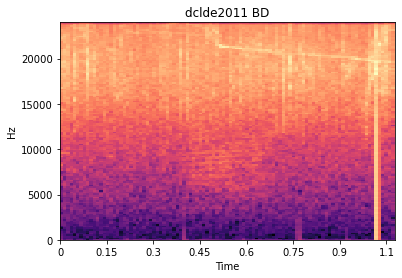

In [44]:
curr_clip_path = os.path.join(dataset_path, '__'+row['dataset'], '__sound_clips', row['filename'])
samples = load_and_normalize(curr_clip_path, sr=fs, clip_length=clip_length)
spectro = librosa.feature.melspectrogram(samples, sr=fs, hop_length=hop_length, power=1)
spectrogram_draw(spectro, row)

## Time & freq shift

In [45]:
def time_freq_shifting_v2(spectro, shift_time, shift_freq):
    # shift_time = random.randrange(-shift_time_max, shift_time_max+1)
    # shift_freq = random.randrange(-shift_freq_max, shift_freq_max+1)
    spectro_shift = np.zeros(spectro.shape)
    # noise_low, noise_high = np.percentile(spectro, [10, 50])
    noise_floor = np.percentile(spectro, [30], axis=1).reshape(-1)
    f_max = spectro_shift.shape[0]
    t_max = spectro_shift.shape[1]
    for i in range(f_max):
        for j in range(t_max):
            if (i-shift_freq >= 0) & (i-shift_freq < f_max) & (j-shift_time >= 0) & (j-shift_time < t_max):
                spectro_shift[i, j] = spectro[i-shift_freq, j-shift_time]
            else:
                if i-shift_freq < 0:
                    i_new = 0
                elif i-shift_freq >= f_max:
                    i_new = f_max - 1
                else:
                    i_new = i-shift_freq
                noise_ij = random.gauss(noise_floor[i_new], noise_floor[i_new]*0.2)
                spectro_shift[i, j] = noise_ij*(noise_ij>=0.0)

    return spectro_shift


<Figure size 864x432 with 0 Axes>

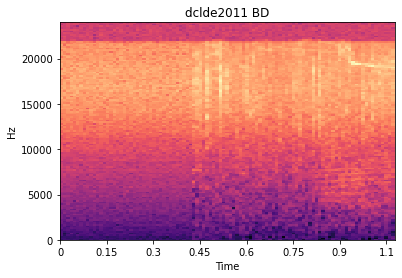

In [46]:
# from lib_augment import *
spectro_shift = time_freq_shifting_v2(spectro, 40, -10)
spectrogram_draw(spectro_shift, row)

<Figure size 864x432 with 0 Axes>

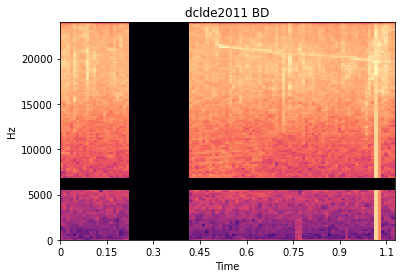

In [49]:
spectrogram_draw(spectro, row)

## warping & masking through SpecAugment

<Figure size 864x432 with 0 Axes>

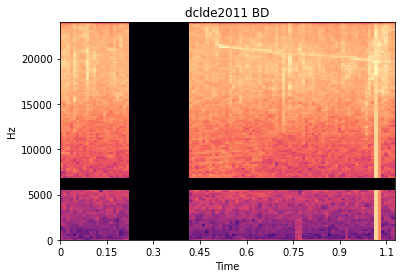

In [48]:
# from specAugment.spec_augment_tensorflow import *
# from specAugment.spec_augment import *
from lib_augment import spec_augment
spectro_warp = spec_augment(spectro, time_warping_para=80, frequency_masking_para=20, time_masking_para=20, num_mask=1)
spectrogram_draw(spectro_warp, row)

## adding noises from another noise clips

In [53]:
row_noise = df_noise.sample(n=1).iloc[0]
curr_noise_path = os.path.join(dataset_path, '__'+dd, '__sound_clips', row_noise['filename'])
spectro_noisy = add_noise_to_signal(curr_noise_path, samples, fs=fs,
                                    clip_length=clip_length, hop_length=hop_length)



/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/__watkin/__sound_clips/NO_STAR2000_48kHz_s46_4755.wav'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

spectrogram_draw(spectro_noisy, row)